# Parking Lots of L.A.

In [1]:
import pandas as pd
import geopandas as gpd
from urllib.request import urlopen 
import jenkspy
import matplotlib.pyplot as plt
%matplotlib inline
import json
import numpy as np
from altair import datum
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
plt.rcParams['figure.figsize'] = (25,15)
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
pd.options.display.float_format = '{:,.0f}'.format
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

---

## Read/plot boundary files

In [2]:
# City of LA
cityboundary = gpd.read_file('input/la-city-boundary.geojson')

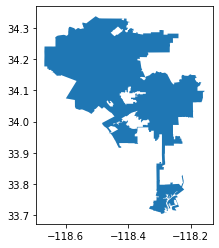

In [3]:
cityboundary.plot()

---

### LA Times neighborhoods in LA County

In [4]:
countyhoods = gpd.read_file('input/la-county-city-neighborhoods.geojson')

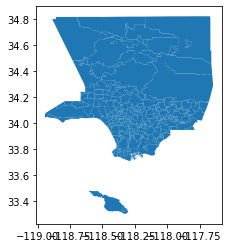

In [5]:
countyhoods.plot()

---

### LA County industrial and commercial parking lots from tax assessor

In [6]:
parkinglots = gpd.read_file('input/parking-lot-parcels.geojson')

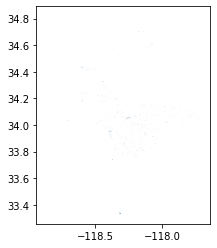

In [7]:
parkinglots.plot()

In [8]:
parkinglots.crs

{'init': 'epsg:4326'}

---

### Reproject parking lots to calculate area

In [9]:
parkinglots = parkinglots.to_crs({'init': "epsg:3311"})
parkinglots.crs

{'init': 'epsg:3311'}

### Calculate area of each parking lot in square feet

In [10]:
parkinglots['area_sq_ft'] = parkinglots.area * 10.764

### What's the area in square miles for all L.A. County parking lots?

In [11]:
parkinglots.area.sum() / 2.59e+6

9.664385352968809

### How many parking lots? 

In [12]:
len(parkinglots)

14932

---

### Clean up the parcels/lots data for analysis

In [13]:
parkinglots.head()

,ogc_fid,ain,assr_map,ownername,owneroverflow,secondowner,objectid,situsdirection,situsunit,situsaddress,situscity,situszip,mailaddress,mailcity,mailzip,designtype1,qualityclass1,yearbuilt1,units1,bedrooms1,bathrooms1,sqftmain1,effectiveyear1,sqftmain2,sqftmain3,...,legaldesclinelast,parcelcreatedate,taxratearea,usecode,usecode_2,usetype,usedescription,roll_year,roll_landvalue,roll_impvalue,roll_landbaseyear,roll_impbaseyear,ownerfullname,parceltypecode,shape.starea(),roll_fixtureexemp,assr_index_map,center_lat,center_lon,center_x,center_y,lat_lon,legaldescription,geometry,area_sq_ft
0,788212,6053003010,6053-003,"KIM,JEAN E",,,371199,S,,9305 S BROADWAY,LOS ANGELES CA,90003-4043,21828 KRATZMEYER RD,BAKERSFIELD CA,93314-9482,2700,DX,1957,0,0,0,"4,400",1957,nan,nan,...,None,0,08835,2700,27,Commercial,Parking Lots (Commercial Use Properties),2019,"196,006",0,2006,2006,"KIM,JEAN E",0,"4,481",0,6053-NDX,34,-118,"6,477,142","1,804,955","33.951790, -118.278706",TRACT # 4715 LOT 87,POLYGON ((159125.7252357852 -450075.1404218008...,"4,481"
1,788213,8307022103,8307-022,CLAREMONT TENNIS CLUB,,,371200,,,,,,1777 MONTE VISTA AVE,CLAREMONT CA,91711-2916,None,None,None,nan,nan,nan,nan,None,nan,nan,...,POR OF LOT 2,20110121,02382,2700,27,Commercial,Parking Lots (Commercial Use Properties),2019,"358,219",0,1999,1999,CLAREMONT TENNIS CLUB,0,"41,342",0,8307-NDX,34,-118,"6,652,821","1,863,807","34.113454, -117.698852",P M 97-12-13 1/2 VAC ST ADJ ON NW AND POR OF L...,POLYGON ((212287.0647664081 -430917.1389335804...,"41,344"
2,788440,7319003107,7319-003,PROLOGIS USLV NEWCA 1 LLC,,,371407,,,,,,1800 WAZEE ST,DENVER CO,80202-1577,None,None,None,nan,nan,nan,nan,None,nan,nan,...,LOT 1,20020102,14989,3800,38,Industrial,Parking Lots (Industrial Use Properties),2019,"323,216","10,773",2015,2015,PROLOGIS USLV NEWCA 1 LLC C/O PROLOGIS - RE TAX,0,"18,344",0,7319-NDX,34,-118,"6,486,535","1,774,980","33.869492, -118.247492",PM 289-13-14 THAT POR IN TRA 14989 OF LOT 1,"POLYGON ((162255.4482437994 -459142.546338731,...","18,343"
3,788465,6021014004,6021-014,"VARGAS,LAZARO M TR",LAZARO M VARGAS TRUST,,371432,,,7508 COMPTON AVE,FLORENCE CA,90001-2627,5907 MIRAMONTE BLVD,LOS ANGELES CA,90001-1325,2700,DX,0000,0,0,0,"3,450",0000,nan,nan,...,LOT 36,0,01198,2700,27,Commercial,Parking Lots (Commercial Use Properties),2019,"39,164","1,342",2001,2001,"VARGAS,LAZARO M TR LAZARO M VARGAS TRUST",0,"3,537",0,6021-NDX,34,-118,"6,486,670","1,812,331","33.972129, -118.247348",TRACT NO 6483 EX OF ST LOT 36,"POLYGON ((161983.262777184 -447765.12024573, 1...","3,537"
4,788538,8367002013,8367-002,CHRISTIAN HARVEST CHURCH,,,371495,,,,,,510 E FOOTHILL BLVD,POMONA CA,91767-1220,2700,,1976,0,0,0,"22,500",1976,nan,nan,...,OF LOT 2 IN SEC 8 T 1S R 8W,0,13362,2700,27,Commercial,Parking Lots (Commercial Use Properties),2019,"781,853","1,171",2008,2008,CHRISTIAN HARVEST CHURCH C/O SEH YUANN WU,0,"25,991",0,8367-NDX,34,-118,"6,640,175","1,861,262","34.106559, -117.740654",LOT COM AT NW COR OF LOT 21 TR NO 22678 TH N 0...,POLYGON ((208448.1370189964 -431812.3212517914...,"25,992"


### Drop columns we don't need

In [14]:
lots = pd.DataFrame(parkinglots[[ 'ogc_fid','ain','assr_map','situsaddress','situscity','situszip',\
                                 'designtype1','qualityclass1','yearbuilt1','effectiveyear1','recdate',\
                                 'lastsaleamount','lastsaledate','parcelcreatedate','taxratearea',\
                                 'usecode','usetype','roll_landvalue',\
                                 'roll_impvalue','roll_landbaseyear','roll_impbaseyear','ownername','ownerfullname',\
                                 'parceltypecode','roll_fixtureexemp',\
                                 'assr_index_map','geometry','area_sq_ft','lat_lon']])

In [15]:
lots.columns = lots.columns.str.replace('1','')

In [16]:
lots.dtypes

ogc_fid                int64
ain                   object
assr_map              object
situsaddress          object
situscity             object
situszip              object
designtype            object
qualityclass          object
yearbuilt             object
effectiveyear         object
recdate               object
lastsaleamount         int64
lastsaledate          object
parcelcreatedate       int64
taxratearea           object
usecode               object
usetype               object
roll_landvalue       float64
roll_impvalue        float64
roll_landbaseyear     object
roll_impbaseyear      object
ownername             object
ownerfullname         object
parceltypecode         int64
roll_fixtureexemp    float64
assr_index_map        object
geometry              object
area_sq_ft           float64
lat_lon               object
dtype: object

In [17]:
lots[['ogc_fid', 'parceltypecode', 'roll_fixtureexemp']] = \
lots[['ogc_fid', 'parceltypecode', 'roll_fixtureexemp']].astype(str)

### Parse dates

In [18]:
lots['parcelcreatedate'] = pd.to_datetime(lots['parcelcreatedate'].astype(str), format='%Y/%m/%d', errors='coerce')
lots['lastsaledate'] = pd.to_datetime(lots['lastsaledate'].astype(str), format='%Y/%m/%d', errors='coerce')
lots['recdate'] = pd.to_datetime(lots['recdate'].astype(str), format='%Y/%m/%d', errors='coerce')

In [19]:
lots.head()

,ogc_fid,ain,assr_map,situsaddress,situscity,situszip,designtype,qualityclass,yearbuilt,effectiveyear,recdate,lastsaleamount,lastsaledate,parcelcreatedate,taxratearea,usecode,usetype,roll_landvalue,roll_impvalue,roll_landbaseyear,roll_impbaseyear,ownername,ownerfullname,parceltypecode,roll_fixtureexemp,assr_index_map,geometry,area_sq_ft,lat_lon
0,788212,6053003010,6053-003,9305 S BROADWAY,LOS ANGELES CA,90003-4043,2700,DX,1957,1957,2005-11-23,700007,2005-11-23,NaT,08835,2700,Commercial,"196,006",0,2006,2006,"KIM,JEAN E","KIM,JEAN E",0,0.0,6053-NDX,POLYGON ((159125.7252357852 -450075.1404218008...,"4,481","33.951790, -118.278706"
1,788213,8307022103,8307-022,,,,None,None,None,None,1998-08-13,9,1994-06-01,2011-01-21,02382,2700,Commercial,"358,219",0,1999,1999,CLAREMONT TENNIS CLUB,CLAREMONT TENNIS CLUB,0,0.0,8307-NDX,POLYGON ((212287.0647664081 -430917.1389335804...,"41,344","34.113454, -117.698852"
2,788440,7319003107,7319-003,,,,None,None,None,None,2015-06-03,68359183,2015-06-03,2002-01-02,14989,3800,Industrial,"323,216","10,773",2015,2015,PROLOGIS USLV NEWCA 1 LLC,PROLOGIS USLV NEWCA 1 LLC C/O PROLOGIS - RE TAX,0,0.0,7319-NDX,"POLYGON ((162255.4482437994 -459142.546338731,...","18,343","33.869492, -118.247492"
3,788465,6021014004,6021-014,7508 COMPTON AVE,FLORENCE CA,90001-2627,2700,DX,0000,0000,2007-05-21,0,2000-12-21,NaT,01198,2700,Commercial,"39,164","1,342",2001,2001,"VARGAS,LAZARO M TR","VARGAS,LAZARO M TR LAZARO M VARGAS TRUST",0,0.0,6021-NDX,"POLYGON ((161983.262777184 -447765.12024573, 1...","3,537","33.972129, -118.247348"
4,788538,8367002013,8367-002,,,,2700,,1976,1976,2008-02-05,2000020,2000-09-29,NaT,13362,2700,Commercial,"781,853","1,171",2008,2008,CHRISTIAN HARVEST CHURCH,CHRISTIAN HARVEST CHURCH C/O SEH YUANN WU,0,0.0,8367-NDX,POLYGON ((208448.1370189964 -431812.3212517914...,"25,992","34.106559, -117.740654"


---

### Look at the county's tax rate areas

In [20]:
tra = pd.read_excel('input/TRA_2014.xlsx')

In [21]:
tra.columns = tra.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [22]:
tra['nu_area'] = tra['area'].astype(str).str.zfill(5)

In [23]:
tra.sort_values(by='area', ascending=True).head(10)

,fy,area,legend,rate,nu_area
21056,2014/2015,1,OTHER SERVICES,0,00001
21055,2014/2015,1,GENERAL,1,00001
76004,2014/2015,2,GENERAL,1,00002
76005,2014/2015,2,OTHER SERVICES,0,00002
38494,2014/2015,3,OTHER SERVICES,0,00003
38493,2014/2015,3,GENERAL,1,00003
49079,2014/2015,4,CITY-LOS ANGELES,0,00004
49080,2014/2015,4,COMMNTY COLLEGE,0,00004
49081,2014/2015,4,COUNTY,0,00004
49084,2014/2015,4,UNIFIED SCHOOLS,0,00004


In [24]:
myhouse = tra[tra['nu_area'] == '00067']

In [25]:
myhouse

,fy,area,legend,rate,nu_area
54622,2014/2015,67,CITY-LOS ANGELES,0,00067
54623,2014/2015,67,COMMNTY COLLEGE,0,00067
54624,2014/2015,67,COUNTY,0,00067
54625,2014/2015,67,GENERAL,1,00067
54626,2014/2015,67,METRO WATER DIST,0,00067
54627,2014/2015,67,UNIFIED SCHOOLS,0,00067
